In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import heapq
import shap

In [2]:
dataset = pd.read_csv('datasetavailable.csv')

In [3]:
# 把需要预测的数据放进y，其他归类到x
X = dataset.drop(['No','tafel(mV/dec)','ECSA(cm2)','Rct','Cdl(mF/cm2)','Overpotential(mV)'],axis=1)
y = dataset[['tafel(mV/dec)','ECSA(cm2)','Rct','Cdl(mF/cm2)','Overpotential(mV)']]

In [4]:
#创建训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 15/77, random_state=42)
print(y_train)

    tafel(mV/dec)  ECSA(cm2)     Rct  Cdl(mF/cm2)  Overpotential(mV)
33           60.0       0.00   4.300        87.00              454.0
9            55.6       0.00   0.000         1.68              293.0
5            71.4       0.00   7.994         3.46              338.0
34           83.0       0.00   6.760        73.60              638.0
22           47.5      27.33   0.000         1.64              336.0
..            ...        ...     ...          ...                ...
20           56.0       8.25  23.300         0.33              343.0
60          171.6       0.00   5.700         1.80              400.0
71           52.0       0.00   0.000         0.00              495.0
14           40.0       0.00   0.000         0.19              258.0
51           53.9       0.00   0.000         0.00              365.0

[62 rows x 5 columns]


In [5]:
#定义网格参数
# n_estimators：森林中树的数量。默认是100
# max_depth：树的最大深度。如果未设置，则节点会扩展直到所有叶子都是纯的，或者直到所有叶子包含的样本少于 min_samples_split
# min_samples_split：分割内部节点所需的最小样本数
# min_samples_leaf：叶节点所需的最小样本数
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 3 , 4],
    'min_samples_leaf': [1, 3, 5]
}

In [6]:
# 创建RandomForestRegressor模型
rfr = RandomForestRegressor(random_state=42)

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid_search.fit(X_train, y_train)

# 查找最优参数
best_params = grid_search.best_params_
# print(best_params)

# 使用最优参数重新训练模型
rfr_best = RandomForestRegressor(**best_params, random_state=42)
rfr_best.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=4, n_estimators=300, random_state=42)

In [7]:
#训练集上数据的误差
y_train_pred = rfr_best.predict(X_train)
y_train_pred_df = pd.DataFrame(y_train_pred, columns=['tafel(mV/dec)','ECSA(cm2)','Rct','Cdl(mF/cm2)','Overpotential(mV)'] )
# 在测试集上评估模型
y_test_pred = rfr_best.predict(X_test)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['tafel(mV/dec)','ECSA(cm2)','Rct','Cdl(mF/cm2)','Overpotential(mV)'] )

# 提取 Overpotential(mV) 列
y_train_overpotential = y_train['Overpotential(mV)']
y_train_pred_overpotential = y_train_pred_df['Overpotential(mV)']

y_test_overpotential = y_test['Overpotential(mV)']
y_test_pred_overpotential = y_test_pred_df['Overpotential(mV)']

# 计算训练集上的误差
mae_train = mean_absolute_error(y_train_overpotential, y_train_pred_overpotential)
mse_train = mean_squared_error(y_train_overpotential, y_train_pred_overpotential)
rmse_train = np.sqrt(mse_train)
nrmse_train = rmse_train / (y_train_overpotential.max() - y_train_overpotential.min())
r2_train = r2_score(y_train_overpotential, y_train_pred_overpotential)

# 计算测试集上的误差
mae_test = mean_absolute_error(y_test_overpotential, y_test_pred_overpotential)
mse_test = mean_squared_error(y_test_overpotential, y_test_pred_overpotential)
rmse_test = np.sqrt(mse_test)
nrmse_test = rmse_test / (y_test_overpotential.max() - y_test_overpotential.min())
r2_test = r2_score(y_test_overpotential, y_test_pred_overpotential)

# 输出结果
print("训练集上的误差（Overpotential(mV)）：")
print(f"MAE: {mae_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"NRMSE: {nrmse_train}")
print(f"R2: {r2_train}")

print("\n测试集上的误差（Overpotential(mV)）：")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"NRMSE: {nrmse_test}")
print(f"R2: {r2_test}")

训练集上的误差（Overpotential(mV)）：
MAE: 44.90126886511044
MSE: 5537.999700634982
RMSE: 74.41773780917411
NRMSE: 0.09664641273918716
R2: 0.7731813010566562

测试集上的误差（Overpotential(mV)）：
MAE: 56.000637155683776
MSE: 6429.080244352831
RMSE: 80.1815455348226
NRMSE: 0.11914048370701724
R2: 0.7147975063457614


In [8]:
#结果
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['tafel(mV/dec)','ECSA(cm2)','Rct','Cdl(mF/cm2)','Overpotential(mV)'] )
y_test.index = range(len(y_test))

In [25]:
plt.rcParams.update({
    # 英文/数字：Times New Roman
    "font.family": ["Times New Roman"],

    # 字体大小：小五号（约 9pt）
    "font.size": 12,          # 全局字体大小
    "axes.titlesize": 14,     # 标题
    "axes.labelsize": 14,     # 坐标轴标签
    "xtick.labelsize": 12,    # X轴刻度
    "ytick.labelsize": 12,    # Y轴刻度
    "legend.fontsize": 14,    # 图例
})

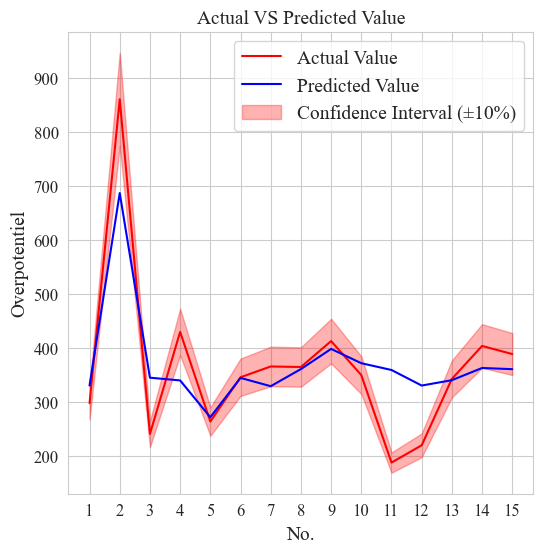

In [26]:
#测试集上模型准确度可视化
#添加置信区间
lower_bound = y_test['Overpotential(mV)'] * 0.9  # 下限（实际值的90%）
upper_bound = y_test['Overpotential(mV)'] * 1.1  # 上限（实际值的110%）
plt.figure(figsize=(6,6))
plt.plot(y_test['Overpotential(mV)'] ,color='red', label = 'Actual Value')
plt.plot(y_test_pred_df['Overpotential(mV)'], color='blue', label='Predicted Value')
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='red', alpha=0.3, label='Confidence Interval (±10%)')
# 设置 x 轴的刻度和标签
x_ticks = np.arange(0, len(y_test))  # 原始刻度位置（0-14）
x_tick_labels = np.arange(1, len(y_test) + 1)  # 新的标签（1-15）
plt.xticks(x_ticks, x_tick_labels)  # 设置刻度位置和标签

plt.title('Actual VS Predicted Value')
plt.xlabel('No.')
plt.ylabel('Overpotentiel')
plt.legend()
plt.show()

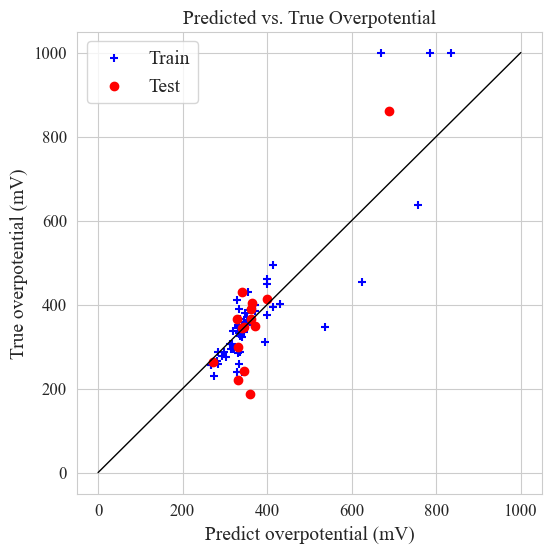

In [27]:
# 画出真实值与预测值的对比图
plt.figure(figsize=(6,6))
plt.scatter(y_train_pred_df['Overpotential(mV)'], y_train['Overpotential(mV)'], color='blue', label='Train', marker='+')
plt.scatter(y_test_pred_df['Overpotential(mV)'], y_test['Overpotential(mV)'], color='red', label='Test', marker='o')
plt.plot([0, 1000], [0, 1000], color='black', linestyle='-', linewidth=1)  # y=x 参考线

plt.xlabel("Predict overpotential (mV)")
plt.ylabel("True overpotential (mV)")
plt.legend()
plt.title("Predicted vs. True Overpotential")
plt.show()

In [12]:
#调用随机生成的数据进行预测
random_dataset = pd.read_csv('random_features.csv')
y_random_pred = rfr_best.predict(random_dataset)

# 将随机生成的数据与预测结果合并
y_random_pred_df = pd.DataFrame(y_random_pred, columns=['tafel(mV/dec)', 'ECSA(cm²)', 'Rct(Ω)', 'Cdl(mF/cm²)', 'Overpotential(mV)'])
random_dataset_with_predictions = pd.concat([random_dataset, y_random_pred_df], axis=1)

# 将随机生成的数据及其预测结果保存到CSV文件
random_dataset_with_predictions.to_csv('random_dataset_with_predictions.csv', index=False)
print("随机数据和预测结果已保存到 random_dataset_with_predictions.csv 文件中。")

# 寻找最低的10个过电位及其对应的x值
top_10 = y_random_pred_df.nsmallest(10, 'Overpotential(mV)')

# 合并最低过电位数据与对应的输入特征
top_10_indices = top_10.index
top_10_full_data = pd.concat([random_dataset.iloc[top_10_indices].reset_index(drop=True), top_10.reset_index(drop=True)], axis=1)

# 将最低10个过电位的完整数据保存到CSV文件
top_10_full_data.to_csv('top_10_lowest_overpotential.csv', index=False)
print("最低10个过电位及其对应数据已保存到 top_10_lowest_overpotential.csv 文件中。")

随机数据和预测结果已保存到 random_dataset_with_predictions.csv 文件中。
最低10个过电位及其对应数据已保存到 top_10_lowest_overpotential.csv 文件中。
